# *SOURCE*
https://www.youtube.com/watch?v=doDUihpj6ro&t=7339s
https://github.com/nicknochnack/ActionDetectionforSignLanguage

In [1]:
! pip install PyQt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 KB 19.8 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python mediapipe 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully u

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [4]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/Tutorial_LSTM_MP/Face_data') 

# Actions that we try to detect
actions = np.array(['HadapKanan', 'HadapKiri', 'HadapDepan'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [5]:
! git clone https://github.com/nickbp760/Tutorial_LSTM_MP.git

Cloning into 'Tutorial_LSTM_MP'...
remote: Enumerating objects: 11362, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 11362 (delta 0), reused 3 (delta 0), pack-reused 11358
Receiving objects: 100% (11362/11362), 104.51 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Updating files: 100% (5421/5421), done.


### **Preprocess Data and Create Labels and Features**

The label map containts the action label

In [6]:
label_map = {label:num for num, label in enumerate(actions)}

In [7]:
label_map

{'HadapKanan': 0, 'HadapKiri': 1, 'HadapDepan': 2}

load the the data that have been prepared before

In [8]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

1404 is an amount of features in one frame, 30 is an amount frames for one video action, 90 is an amount of 
video actions

In [9]:
468*3

1404

In [10]:
np.array(sequences).shape

(90, 30, 1404)

DEFINE X (Input) and y (Output)

In [11]:
X = np.array(sequences)
print(X.shape)
y = to_categorical(labels).astype(int)
print(y.shape)

(90, 30, 1404)
(90, 3)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [13]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

### **Build and Train LSTM Neural Network**

In [14]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [15]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1404)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.optimizer.lr.assign(0.1)

In [18]:
history = model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/500
3/3 [==============================] - 7s 464ms/step - loss: 149.1107 - categorical_accuracy: 0.3210 - val_loss: 109.0976 - val_categorical_accuracy: 0.1111
Epoch 2/500
3/3 [==============================] - 1s 401ms/step - loss: 103.9984 - categorical_accuracy: 0.2469 - val_loss: 51.0683 - val_categorical_accuracy: 0.1111
Epoch 3/500
3/3 [==============================] - 1s 424ms/step - loss: 37.7609 - categorical_accuracy: 0.2593 - val_loss: 56.3936 - val_categorical_accuracy: 0.4444
Epoch 4/500
3/3 [==============================] - 1s 382ms/step - loss: 68.3135 - categorical_accuracy: 0.3086 - val_loss: 46.0223 - val_categorical_accuracy: 0.1111
Epoch 5/500
3/3 [==============================] - 1s 418ms/step - loss: 109.3935 - categorical_accuracy: 0.3704 - val_loss: 70.3717 - val_categorical_accuracy: 0.2222
Epoch 6/500
3/3 [==============================] - 1s 207ms/step - loss: 98.2886 - categorical_accuracy: 0.4568 - val_loss: 668.0726 - val_categorical_accuracy: 

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            376064    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 530,627
Trainable params: 530,627
Non-trai

In [20]:
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionFace.h5')

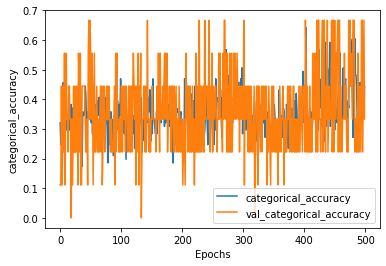

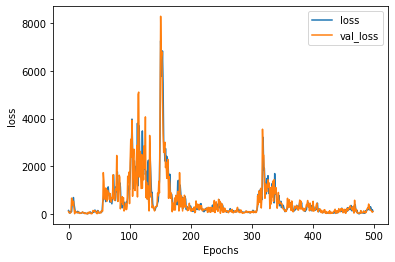

In [21]:
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')

In [22]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(30,1404)))
model.add(GRU(64, return_sequences=True, activation='relu'))
model.add(GRU(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [23]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.optimizer.lr.assign(0.005)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.005>

In [24]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 5s 209ms/step - loss: 1.0464 - categorical_accuracy: 0.3704
Epoch 2/500
3/3 [==============================] - 1s 212ms/step - loss: 0.7970 - categorical_accuracy: 0.6790
Epoch 3/500
3/3 [==============================] - 1s 206ms/step - loss: 0.7015 - categorical_accuracy: 0.6790
Epoch 4/500
3/3 [==============================] - 1s 197ms/step - loss: 0.7525 - categorical_accuracy: 0.6790
Epoch 5/500
3/3 [==============================] - 1s 178ms/step - loss: 0.6563 - categorical_accuracy: 0.8272
Epoch 6/500
3/3 [==============================] - 1s 197ms/step - loss: 0.4671 - categorical_accuracy: 1.0000
Epoch 7/500
3/3 [==============================] - 1s 201ms/step - loss: 0.4319 - categorical_accuracy: 0.9506
Epoch 8/500
3/3 [==============================] - 1s 207ms/step - loss: 0.4835 - categorical_accuracy: 0.8148
Epoch 9/500
3/3 [==============================] - 1s 209ms/step - loss: 0.4103 - categorical_accuracy: 0.9506
E

### **Make One Predictions**

In [25]:
res = model.predict(X_test)

In [26]:

actions[np.argmax(res[4])]

'HadapDepan'

In [27]:
actions[np.argmax(y_test[4])]

'HadapDepan'

### **ReLoad Model**

In [28]:
del model

In [29]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1404)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
model.load_weights('/content/Tutorial_LSTM_MP/Weight_model/actionFace.h5')

### **Evaluation using Confusion Matrix and Accuracy**

In [31]:
y_test_predict = model.predict(X_test)

In [32]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(y_test_predict, axis=1).tolist()

In [33]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 5],
        [0, 2]],

       [[5, 1],
        [2, 1]],

       [[5, 0],
        [4, 0]]])

In [34]:
accuracy_score(ytrue, yhat)

0.3333333333333333